# preparation

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

nb of games: 64


In [4]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:06<00:00, 10.17it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'type_name', 'result_name', 'bodypart_name',
       'player_name', 'player_nickname', 'jersey_number', 'country_id',
       'country_name', 'extra', 'team_name', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

# Most valuable players in the world cup

## prepare master dataframe

In [25]:
mst_df = pd.read_csv(os.path.join('..','data','mst_player_position.csv'))
mst_df = pd.merge(mst_df, A[['player_nickname','player_name']].drop_duplicates(), on='player_name', how='left')

mst_df["player"] = mst_df[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

## summarize

In [5]:
A["player"] = A[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

A["count"] = 1

A_ = A[A.type_name != "shot_penalty"] # ignore penalties
players = (
    A_[["player_id","team_name","player","vaep_value","count"]]
    .groupby(["player_id","team_name","player"])
    .sum()
    .reset_index()
)
players = players.sort_values("vaep_value",ascending=False)
players

,player_id,team_name,player,vaep_value,count
6,3009,France,Kylian Mbappé,4.022927,495
50,3308,England,Kieran Trippier,3.787583,689
122,4320,Brazil,Neymar,3.383777,749
92,3621,Belgium,Eden Hazard,3.328818,690
152,5186,Russia,Denis Cheryshev,3.194341,213
...,...,...,...,...,...
186,5223,Morocco,Aziz Bouhaddouz,-0.959839,9
30,3202,Brazil,Gabriel Jesus,-1.005869,273
117,4269,Serbia,Aleksandar Mitrović,-1.334005,171
343,5565,Germany,Mario Gómez,-1.335697,33


# Normalize for minutes played

In [26]:
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()
stats = players.merge(mp)
stats = stats[stats.minutes_played > 150]
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats.sort_values("vaep_value",ascending=False)

,player_id,team_name,player,vaep_value,count,minutes_played,vaep_rating
0,3009,France,Kylian Mbappé,4.022927,495,550,0.658297
1,3308,England,Kieran Trippier,3.787583,689,602,0.566250
2,4320,Brazil,Neymar,3.383777,749,478,0.637113
3,3621,Belgium,Eden Hazard,3.328818,690,540,0.554803
4,5186,Russia,Denis Cheryshev,3.194341,213,312,0.921444
...,...,...,...,...,...,...,...
595,11098,Sweden,Marcus Berg,-0.927424,207,435,-0.191881
596,3604,France,Olivier Giroud,-0.944225,324,566,-0.150142
598,3202,Brazil,Gabriel Jesus,-1.005869,273,416,-0.217616
599,4269,Serbia,Aleksandar Mitrović,-1.334005,171,271,-0.443028


In [27]:
stats['countPer90minutes'] = stats['count']/stats['minutes_played']*90

## top 10 players

In [28]:
stats.sort_values('vaep_rating',ascending=False).head(10)

,player_id,team_name,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
4,5186,Russia,Denis Cheryshev,3.194341,213,312,0.921444,61.442308
10,5574,Germany,Toni Kroos,2.778240,647,289,0.865196,201.487889
28,5674,Senegal,Moussa Wagué,1.701559,168,208,0.736251,72.692308
26,5473,Nigeria,Ahmed Musa,1.776397,162,220,0.726708,66.272727
15,6196,Colombia,Yerry Mina,2.449056,325,315,0.699730,92.857143
13,4319,Uruguay,Edinson Cavani,2.654940,226,355,0.673083,57.295775
0,3009,France,Kylian Mbappé,4.022927,495,550,0.658297,81.000000
39,3237,Argentina,Sergio Agüero,1.404612,137,193,0.655000,63.886010
12,5503,Argentina,Lionel Messi,2.704808,524,378,0.644002,124.761905
2,4320,Brazil,Neymar,3.383777,749,478,0.637113,141.025105


## groupby position

In [121]:
mst_df = pg.groupby(['player_id', 'position_name']).minutes_played.sum().reset_index()
mst_df = mst_df.loc[mst_df.groupby('player_id').minutes_played.idxmax(),:][['player_id', 'position_name']]

In [125]:
stats_ = pd.merge(mst_df[['player_id','position_name']], stats, on=['player_id'], how='left')

In [40]:
position_name_list_dict = {
    'Goalkeeper':['Goalkeeper'],
    'Center Back':['Center Back', 'Right Center Back', 'Left Center Back'],
    'Side, Wing Back':['Right Back', 'Left Back', 'Right Wing Back', 'Left Wing Back'],
    'Defensive Midfield':['Left Defensive Midfield', 'Center Defensive Midfield', 'Right Defensive Midfield'],
    'Center Midfield':['Left Center Midfield','Center Midfield','Right Center Midfield'],
    'Attacking Midfield':['Left Attacking Midfield', 'Center Attacking Midfield', 'Right Attacking Midfield'],
    'Side Half, Wing':['Left Midfield', 'Right Midfield', 'Left Wing', 'Right Wing'],
    'Forward':['Secondary Striker', 'Left Center Forward', 'Center Forward', 'Right Center Forward']
}

In [68]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

In [69]:
def imscatter(x, y, image, ax=None, zoom=1): 
    if ax is None: 
        ax = plt.gca() 
    try: 
        image = plt.imread(image) 
    except:
        pass 
    im = OffsetImage(image, zoom=zoom) 
    artists = [] 
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False) 
    artists.append(ax.add_artist(ab))
    '''
    for x0, y0 in zip(x, y): 
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False) 
        artists.append(ax.add_artist(ab)) 
    '''
    return artists 

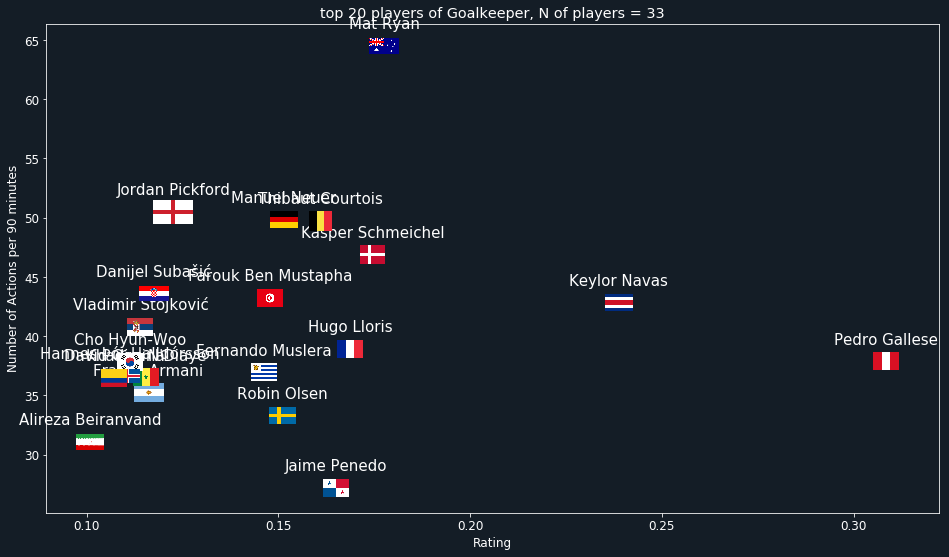

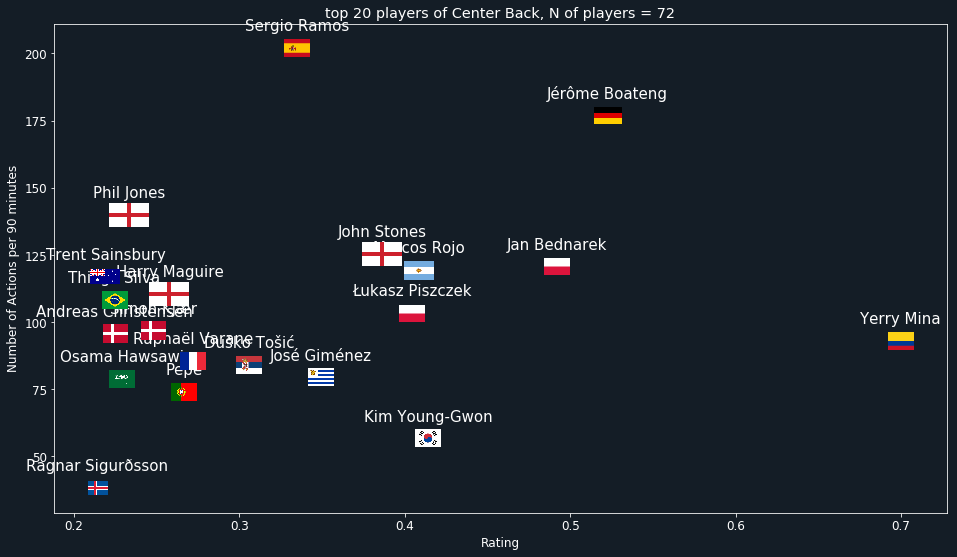

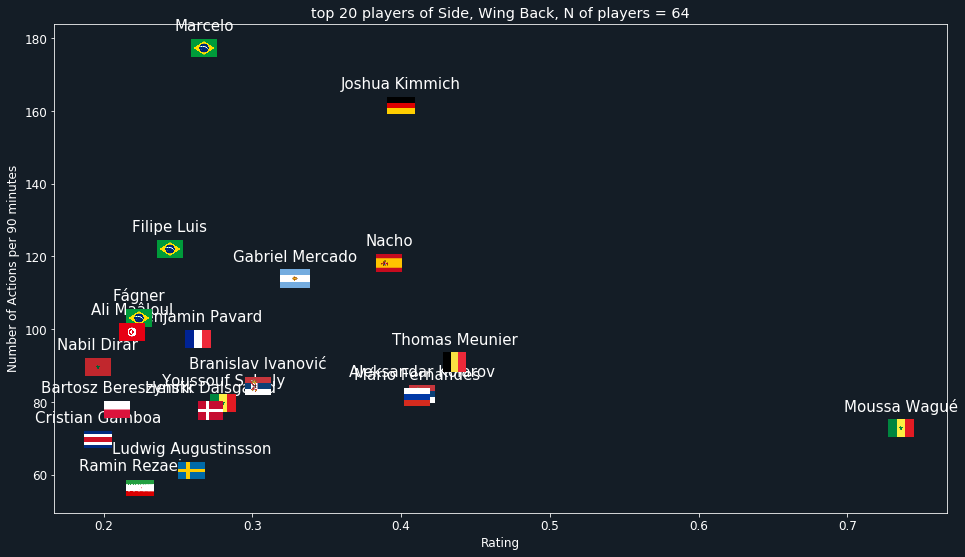

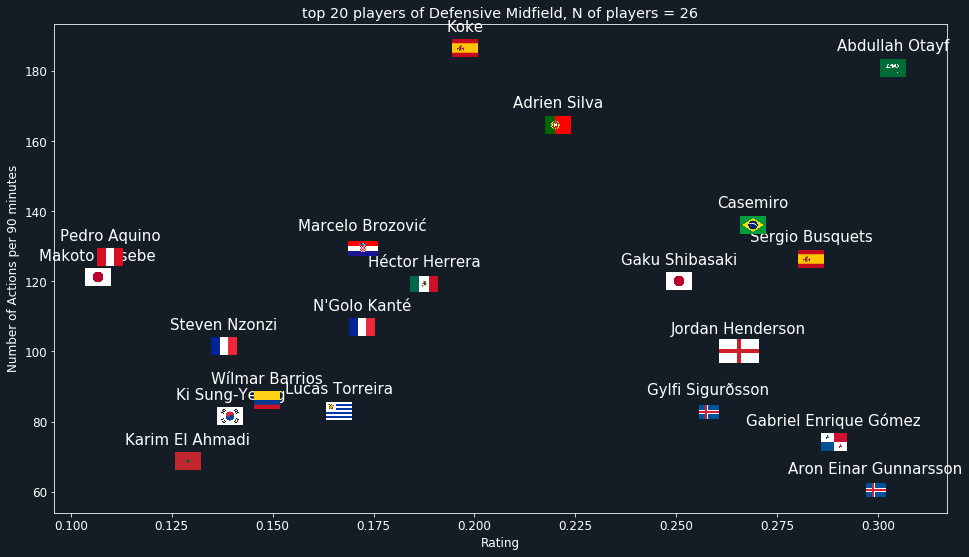

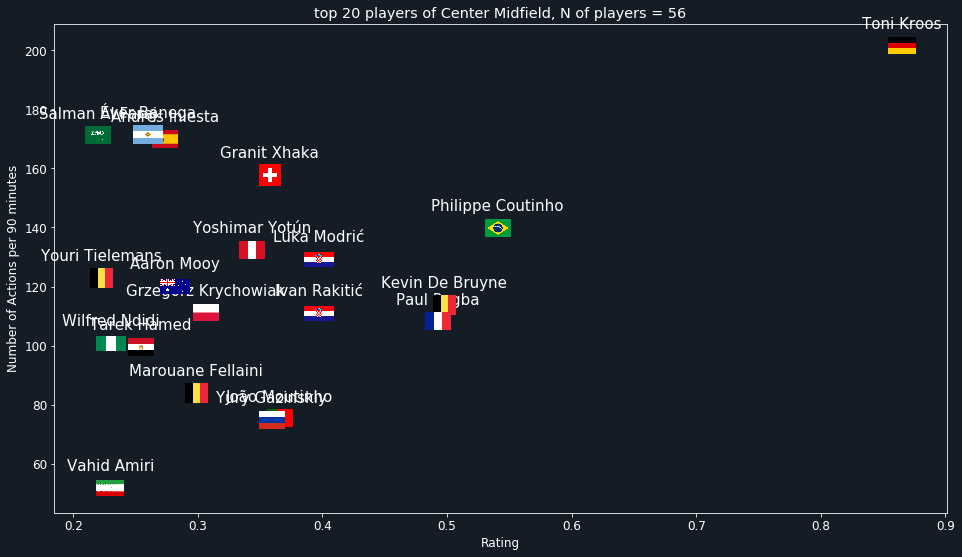

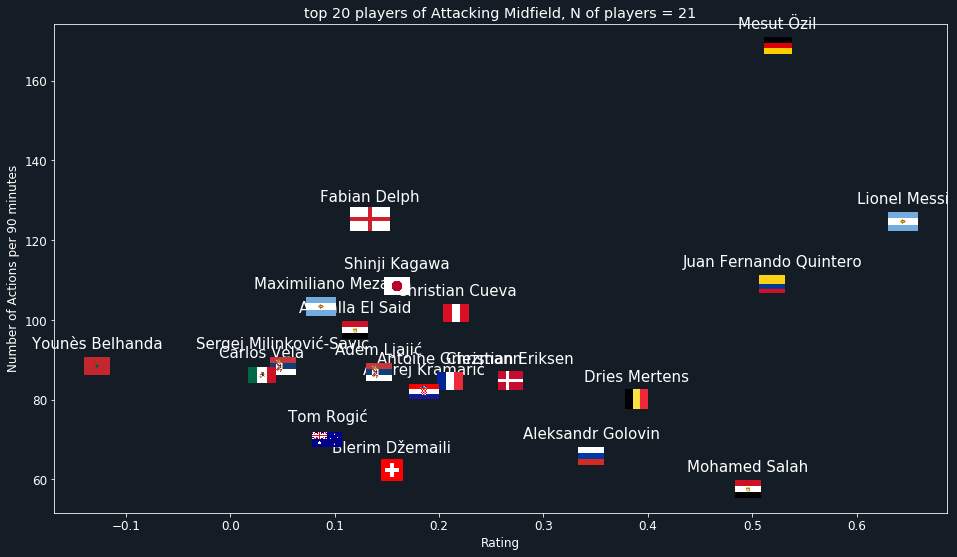

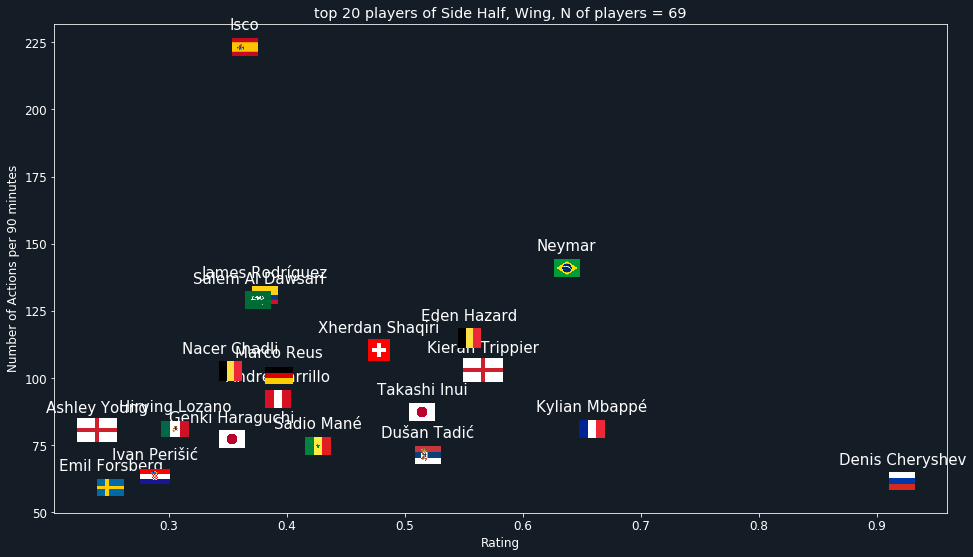

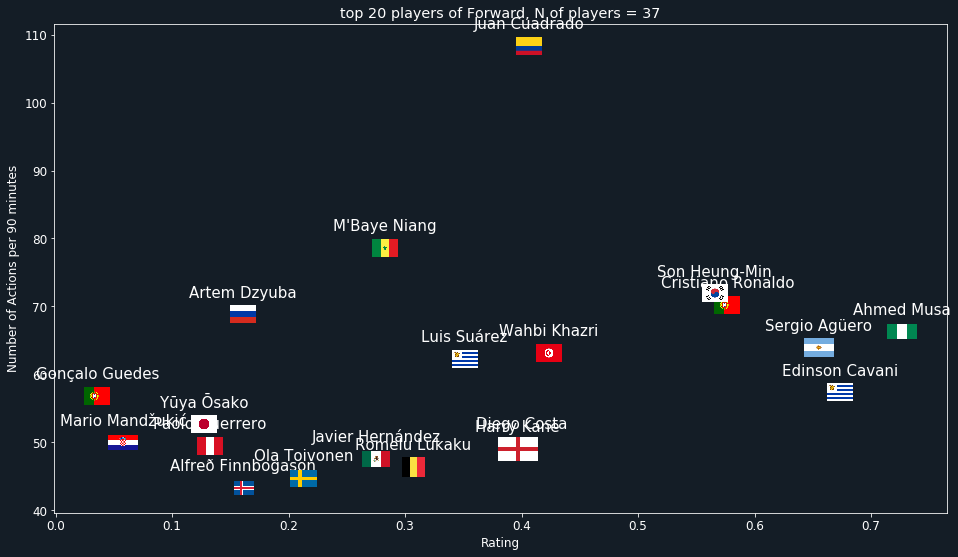

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.get_cmap('tab10')

flagdir = os.path.join('..','..','statsbomb','reports','flag')

twitter_color = '#141d26'
plt.rcParams["font.size"] = 12
# 文字カラーを白に
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = plt.rcParams['ytick.color'] = COLOR

top_N = 20

for position_name, position_name_list in position_name_list_dict.items():
    stats_tmp = stats_[stats_.position_name.isin(position_name_list)].drop_duplicates(subset=['player'])
#     print(f'{position_name}, N of players = {len(stats_tmp)}')
#     display(stats_tmp.drop('position_name', axis=1).sort_values('vaep_rating',ascending=False).head(10))
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.spines['bottom'].set_color('white'); ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white'); ax.spines['top'].set_color('white')
    fig.patch.set_facecolor(twitter_color)
    ax.patch.set_facecolor(twitter_color)
    ax.set_title(f'top {top_N} players of {position_name}, N of players = {len(stats_tmp)}')
    ymin, ymax = stats_tmp.sort_values('vaep_rating',ascending=False).head(top_N).countPer90minutes.min(), stats_tmp.sort_values('vaep_rating',ascending=False).head(top_N).countPer90minutes.max()
    for i in stats_tmp.drop('position_name', axis=1).sort_values('vaep_rating',ascending=False).head(top_N).index:

        team_name = stats_tmp.loc[i,'team_name']
        vaep_rating, countPer90minutes = stats_tmp.loc[i,['vaep_rating','countPer90minutes']]

        image_path = os.path.join(flagdir,f'{team_name}.png')
        if team_name == 'Iceland':
            imscatter(vaep_rating, countPer90minutes, image_path, ax=ax,  zoom=.01) 
        else:    
            imscatter(vaep_rating, countPer90minutes, image_path, ax=ax,  zoom=.1) 

        ax.text(x=vaep_rating,y=countPer90minutes+(ymax-ymin)*0.04, s=stats_tmp.loc[i,'player'], fontsize=15, horizontalalignment='center')
        ax.scatter(x=vaep_rating,y=countPer90minutes,color=cmap(0))
    
#     ax.set_ylim([stats_tmp['countPer90minutes'].min(), stats_tmp['countPer90minutes'].max()])
    ax.set_ylabel('Number of Actions per 90 minutes')
#     ax.set_xlim([stats_tmp['vaep_rating'].min(), stats_tmp['vaep_rating'].max()])
    ax.set_xlabel('Rating')
    plt.savefig(os.path.join('..','fig',f'{position_name}.png'), bbox_inches='tight', facecolor=twitter_color)

## scatter plot

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
cmap = plt.get_cmap('tab10')

stats.sort_values('vaep_rating', inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(10):
#     ax.annotate(xy=[stats.loc[i,'vaep_rating'],stats.loc[i,'per90minutes']], s=stats.loc[i,'player'], fontsize=8)
    ax.text(x=stats.loc[i,'vaep_rating'],y=stats.loc[i,'per90minutes'], s=stats.loc[i,'player'], fontsize=10)
    ax.scatter(x=stats.loc[i,'vaep_rating'],y=stats.loc[i,'per90minutes'],color=cmap(0))
    
ax.set_ylim([stats['per90minutes'].min(), stats['per90minutes'].max()]); ax.set_ylabel('Number of Actions per 90 minutes')
ax.set_xlim([stats['vaep_rating'].min(), stats['vaep_rating'].max()]); ax.set_xlabel('Rating')

In [61]:
for team in stats['team_name'].unique():
    print(team)
    display(stats[stats.team_name==team].sort_values('vaep_rating', ascending=False).drop('team_name', axis=1))

Colombia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
15,6196,Yerry Mina,2.449056,325,315,0.699730,92.857143
25,5692,Juan Fernando Quintero,1.782824,374,309,0.519269,108.932039
33,5689,Juan Cuadrado,1.556575,415,345,0.406063,108.260870
137,5695,James Rodríguez,0.691292,237,163,0.381695,130.858896
260,6193,Mateus Uribe,0.343958,198,195,0.158750,91.384615
206,5686,Wílmar Barrios,0.473612,274,287,0.148519,85.923345
163,5691,Johan Mojica,0.594201,446,410,0.130434,97.902439
189,3494,Davinson Sánchez,0.511706,408,410,0.112326,89.560976
197,4276,David Ospina,0.488145,166,410,0.107154,36.439024
239,5696,Santiago Arias,0.390878,396,398,0.088390,89.547739


Serbia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
34,3831,Dušan Tadić,1.552435,213,269,0.519402,71.263941
51,5596,Aleksandar Kolarov,1.310351,260,285,0.413795,82.105263
151,5580,Duško Tošić,0.652242,179,192,0.305739,83.906250
153,5594,Branislav Ivanović,0.648446,180,192,0.303959,84.375000
221,3455,Luka Milivojević,0.423046,145,177,0.215108,73.728814
147,5603,Nikola Milenković,0.664201,230,285,0.209748,72.631579
280,5587,Adem Ljajić,0.276869,169,175,0.142390,86.914286
250,5601,Vladimir Stojković,0.361184,129,285,0.114058,40.736842
274,3381,Nemanja Matić,0.294822,302,285,0.093102,95.368421
351,5591,Filip Kostić,0.156451,130,172,0.081864,68.023256


Egypt


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
78,3531,Mohamed Salah,1.041536,121,189,0.495969,57.619048
143,5262,Tarek Hamed,0.672203,263,238,0.254194,99.453782
174,5263,Mohamed Abdul Shafy,0.568790,334,285,0.179618,105.473684
187,4063,Ahmed Hegazi,0.524964,249,285,0.165778,78.631579
219,5261,Trézéguet,0.437284,223,243,0.161957,82.592593
226,3568,Mohamed Elneny,0.414361,219,254,0.146821,77.598425
265,5251,Abdalla El Said,0.321085,261,241,0.119907,97.468880
342,5265,Mohamed El Shenawy,0.174945,68,190,0.082869,32.210526
441,5253,Amr Warda,0.019434,150,156,0.011212,86.538462
584,5250,Ahmed Fathy,-0.467802,310,285,-0.147727,97.894737


Australia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
95,3281,Aaron Mooy,0.881912,376,282,0.281461,120.000000
140,5478,Trent Sainsbury,0.686381,366,282,0.219058,116.808511
146,5488,Mark Milligan,0.666794,485,282,0.212806,154.787234
156,5489,Mile Jedinak,0.638172,305,282,0.203672,97.340426
179,3240,Mat Ryan,0.556677,202,282,0.177663,64.468085
312,5491,Tom Rogić,0.229701,173,222,0.093122,70.135135
550,5482,Josh Risdon,-0.203935,296,282,-0.065086,94.468085
551,5494,Robbie Kruse,-0.207850,118,207,-0.090369,51.304348
574,5481,Mathew Leckie,-0.402390,219,282,-0.128422,69.893617
594,5479,Aziz Behich,-0.832284,365,282,-0.265623,116.489362


Brazil


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
2,4320,Neymar,3.383777,749,478,0.637113,141.025105
11,3501,Philippe Coutinho,2.720943,703,453,0.540585,139.668874
79,5539,Casemiro,1.034060,523,346,0.268975,136.040462
94,5552,Marcelo,0.885377,587,298,0.267396,177.281879
196,6320,Filipe Luis,0.488252,244,180,0.244126,122.000000
63,3295,Thiago Silva,1.191841,575,478,0.224405,108.263598
90,5838,Fágner,0.950342,437,382,0.223903,102.958115
119,5542,Paulinho,0.769554,337,350,0.197885,86.657143
165,3472,Willian,0.586948,437,369,0.143158,106.585366
176,5551,João Miranda,0.566513,512,478,0.106666,96.401674


Poland


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
52,4626,Jan Bednarek,1.296163,317,237,0.492214,120.379747
112,5658,Łukasz Piszczek,0.794862,203,177,0.404167,103.220339
89,3637,Grzegorz Krychowiak,0.960565,348,282,0.306563,111.063830
231,5673,Bartosz Bereszyński,0.408966,152,176,0.209130,77.727273
245,5670,Michał Pazdan,0.373901,289,173,0.194515,150.346821
217,5660,Piotr Zieliński,0.441920,321,267,0.148962,108.202247
298,6195,Jacek Góralski,0.247249,143,188,0.118364,68.457447
285,5667,Kamil Grosicki,0.270052,143,226,0.107543,56.946903
331,5672,Maciej Rybus,0.188172,153,189,0.089606,72.857143
339,5669,Wojciech Szczęsny,0.177718,75,189,0.084628,35.714286


Saudi Arabia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
65,5187,Salem Al Dawsari,1.181615,405,283,0.375779,128.798587
99,5173,Abdullah Otayf,0.850214,506,252,0.303648,180.714286
130,5184,Osama Hawsawi,0.720436,248,283,0.229114,78.869258
139,5178,Salman Al Faraj,0.690316,538,283,0.219535,171.095406
232,5191,Mohammed Al Burayk,0.408794,451,283,0.130005,143.427562
303,5183,Yasir Al Shahrani,0.238628,389,283,0.075889,123.710247
543,5190,Fahad Al Muwallad,-0.162488,86,186,-0.078623,41.612903
572,5188,Hattan Babhir,-0.359462,154,161,-0.200942,86.086957


Mexico


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
74,5571,Hirving Lozano,1.101322,292,325,0.304981,80.861538
77,3058,Javier Hernández,1.043649,180,341,0.275450,47.507331
214,5561,Hugo Ayala,0.448186,137,189,0.213422,65.238095
132,5556,Miguel Layún,0.712626,273,327,0.196136,75.137615
115,5575,Héctor Herrera,0.787426,501,378,0.187482,119.285714
138,5576,Jesús Gallardo,0.690472,365,348,0.178570,94.396552
180,5564,Carlos Salcedo,0.556658,447,378,0.132538,106.428571
323,5563,Andrés Guardado,0.203850,302,309,0.059374,87.961165
376,5560,Carlos Vela,0.109461,309,323,0.030500,86.099071
433,5577,Guillermo Ochoa,0.026034,175,378,0.006199,41.666667


Panama


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
102,5640,Gabriel Enrique Gómez,0.831667,213,259,0.288996,74.015444
172,5638,Fidel Escobar,0.572472,176,285,0.180781,55.578947
188,5636,Jaime Penedo,0.522665,86,285,0.165052,27.157895
314,5637,Édgar Yoel Bárcenas,0.227041,174,227,0.090016,68.986784
349,5634,Erick Davis,0.160587,210,188,0.076877,100.531915
327,5646,Aníbal Godoy,0.197245,226,252,0.070444,80.714286
408,5645,Armando Cooper,0.055687,178,188,0.026659,85.212766
399,5635,Román Torres,0.063858,152,243,0.023651,56.296296
556,5628,José Rodríguez,-0.227558,165,253,-0.080949,58.695652
561,5631,Blas Pérez,-0.267232,68,167,-0.144017,36.646707


Sweden


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
41,5621,Ludwig Augustinsson,1.370261,323,476,0.259083,61.071429
62,5625,Emil Forsberg,1.194391,282,429,0.250572,59.160839
88,4417,Ola Toivonen,0.963786,202,407,0.213122,44.668305
142,5617,Sebastian Larsson,0.676113,307,328,0.185519,84.237805
96,5613,Viktor Claesson,0.869808,324,452,0.173192,64.513274
150,5612,Mikael Lustig,0.655840,237,366,0.161272,58.278689
110,5622,Robin Olsen,0.799440,176,476,0.151155,33.277311
185,3702,Victor Lindelöf,0.542037,212,382,0.127705,49.947644
175,5624,Albin Ekdal,0.568449,366,437,0.117072,75.377574
191,5607,Andreas Granqvist,0.502480,361,476,0.095007,68.256303


Germany


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
10,5574,Toni Kroos,2.778240,647,289,0.865196,201.487889
71,3496,Mesut Özil,1.117982,360,192,0.524054,168.750000
73,5578,Jérôme Boateng,1.103393,373,190,0.522660,176.684211
54,5579,Joshua Kimmich,1.283046,518,289,0.399565,161.314879
81,5559,Marco Reus,1.005236,258,230,0.393353,100.956522
199,5570,Manuel Neuer,0.486153,160,289,0.151397,49.826990
292,5572,Mats Hummels,0.259233,212,192,0.121516,99.375000
430,5557,Timo Werner,0.031272,212,281,0.010016,67.900356
455,6040,Jonas Hector,0.005471,204,163,0.003021,112.638037
583,5562,Thomas Müller,-0.451378,229,227,-0.178961,90.792952


Nigeria


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
26,5473,Ahmed Musa,1.776397,162,220,0.726708,66.272727
128,3338,Wilfred Ndidi,0.726064,318,284,0.230091,100.774648
158,5475,John Obi Mikel,0.627104,311,277,0.203752,101.046931
212,5462,Brian Idowu,0.455119,172,233,0.175797,66.437768
190,3963,Victor Moses,0.510673,262,284,0.161833,83.028169
291,5830,Kenneth Omeruo,0.260470,152,185,0.126715,73.945946
300,5454,Francis Uzoho,0.245188,93,284,0.077700,29.471831
538,5467,Leon-Aderemi Balogun,-0.143602,232,284,-0.045508,73.521127
559,5466,Peter Etebo,-0.265877,350,277,-0.086386,113.718412
552,3708,Kelechi Iheanacho,-0.208427,97,152,-0.123411,57.434211


Argentina


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
39,3237,Sergio Agüero,1.404612,137,193,0.655000,63.886010
12,5503,Lionel Messi,2.704808,524,378,0.644002,124.761905
76,3602,Marcos Rojo,1.062527,310,234,0.408664,119.230769
80,5742,Gabriel Mercado,1.033597,358,283,0.328706,113.851590
145,5504,Éver Banega,0.667834,440,231,0.260195,171.428571
157,2995,Ángel Di María,0.627265,198,240,0.235224,74.250000
122,3090,Nicolás Otamendi,0.767393,571,378,0.182713,135.952381
192,5506,Javier Mascherano,0.497881,664,378,0.118543,158.095238
301,6312,Franco Armani,0.243942,74,189,0.116163,35.238095
318,5499,Maximiliano Meza,0.214260,254,221,0.087255,103.438914


Switzerland


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
21,3533,Xherdan Shaqiri,1.949615,450,367,0.478107,110.354223
36,3500,Granit Xhaka,1.516222,669,382,0.357225,157.617801
178,5548,Steven Zuber,0.559866,205,260,0.193800,70.961538
117,5544,Ricardo Rodríguez,0.778605,426,382,0.183441,100.366492
201,5541,Stephan Lichtsteiner,0.480358,288,276,0.156638,93.913043
169,5554,Blerim Džemaili,0.575373,232,335,0.154578,62.328358
204,5540,Valon Behrami,0.478229,467,319,0.134923,131.755486
330,5545,Breel Embolo,0.189392,116,159,0.107203,65.660377
216,5549,Manuel Akanji,0.442240,590,382,0.104193,139.005236
273,5537,Fabian Schär,0.295331,415,286,0.092936,130.594406


Costa Rica


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
120,5597,Keylor Navas,0.769388,138,290,0.238776,42.827586
215,5598,Óscar Duarte,0.445631,163,195,0.205676,75.230769
170,5602,Cristian Gamboa,0.572797,203,263,0.196014,69.467681
223,5584,Giancarlo González,0.420365,174,290,0.130458,54.000000
287,5836,Bryan Oviedo,0.267958,132,193,0.124955,61.554404
258,5592,Bryan Ruiz,0.349313,285,290,0.108408,88.448276
262,5582,Celso Borges,0.335492,233,290,0.104118,72.310345
332,5590,Johnny Acosta,0.185462,146,290,0.057557,45.310345
353,5599,David Guzmán,0.153717,248,244,0.056699,91.475410
560,5595,Johan Venegas,-0.266133,114,157,-0.152561,65.350318


France


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
0,3009,Kylian Mbappé,4.022927,495,550,0.658297,81.000000
7,20004,Paul Pogba,3.081210,676,563,0.492556,108.063943
20,5485,Raphaël Varane,2.001598,628,662,0.272121,85.377644
29,5476,Benjamin Pavard,1.667134,615,569,0.263694,97.275923
44,5492,Samuel Umtiti,1.332716,420,569,0.210799,66.432337
42,5487,Antoine Griezmann,1.354329,546,580,0.210155,84.724138
207,5480,Corentin Tolisso,0.467826,279,211,0.199547,119.004739
64,3961,N'Golo Kanté,1.187832,737,621,0.172150,106.811594
75,3099,Hugo Lloris,1.066844,246,569,0.168745,38.910369
295,5737,Steven Nzonzi,0.255853,188,167,0.137885,101.317365


Denmark


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
58,4763,Henrik Dalsgaard,1.235526,353,409,0.271876,77.677262
59,3043,Christian Eriksen,1.218938,385,409,0.268226,84.718826
70,5534,Simon Kjær,1.127145,440,409,0.248027,96.821516
118,3959,Andreas Christensen,0.776537,330,311,0.224721,95.498392
113,3815,Kasper Schmeichel,0.793327,213,409,0.174571,46.870416
222,5520,Lasse Schöne,0.421321,257,236,0.160673,98.008475
241,5516,Pione Sisto,0.388562,233,241,0.145106,87.012448
253,5527,Thomas Delaney,0.355042,380,376,0.084984,90.957447
320,5524,Jens Stryger Larsen,0.209389,208,281,0.067064,66.619217
391,3027,Zanka,0.084167,202,236,0.032098,77.033898


Iceland


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
100,5515,Aron Einar Gunnarsson,0.848282,171,255,0.299394,60.352941
104,3944,Gylfi Sigurðsson,0.816998,262,285,0.257999,82.736842
184,5511,Ragnar Sigurðsson,0.542904,97,228,0.214304,38.289474
202,5514,Alfreð Finnbogason,0.479649,129,268,0.161076,43.320896
290,5505,Kári Árnason,0.261004,101,191,0.122986,47.591623
255,5498,Hannes Þór Halldórsson,0.352377,116,285,0.111277,36.631579
268,5508,Birkir Már Sævarsson,0.315652,147,285,0.099680,46.421053
357,3720,Johann Gudmundsson,0.143371,117,156,0.082714,67.500000
360,5512,Emil Hallfreðsson,0.137939,150,189,0.065685,71.428571
547,5509,Birkir Bjarnason,-0.174076,160,280,-0.055953,51.428571


Morocco


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
225,5727,Nabil Dirar,0.415962,190,191,0.196003,89.528796
177,5245,Achraf Hakimi,0.562480,254,287,0.176388,79.651568
259,5244,Medhi Benatia,0.345022,243,191,0.162576,114.502618
261,5219,Romain Saïss,0.335775,182,192,0.157395,85.312500
205,5237,Hakim Ziyech,0.476219,305,275,0.155854,99.818182
257,5221,Manuel da Costa,0.350611,157,206,0.153180,68.592233
236,5236,Karim El Ahmadi,0.397055,211,277,0.129007,68.555957
288,3302,Nordin Amrabat,0.266709,232,266,0.090240,78.496241
306,5232,Mbark Boussoufa,0.236100,262,287,0.074038,82.160279
313,5233,Munir,0.228683,92,287,0.071713,28.850174


Iran


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
134,5241,Vahid Amiri,0.709930,160,278,0.229833,51.798561
131,5235,Ramin Rezaeian,0.715379,180,287,0.224335,56.445993
238,5230,Ehsan Hajsafi,0.390990,135,219,0.160681,55.479452
282,5239,Alireza Jahanbakhsh,0.275386,121,173,0.143264,62.947977
248,5220,Morteza Pouraliganji,0.366154,111,287,0.114822,34.808362
264,5227,Alireza Beiranvand,0.321630,99,287,0.100860,31.045296
302,5225,Omid Ebrahimi,0.241631,153,270,0.080544,51.000000
385,5228,Majid Hosseini,0.093407,72,208,0.040417,31.153846
415,5231,Karim Ansarifard,0.048993,89,191,0.023085,41.937173
526,5722,Saeid Ezatolahi,-0.096496,103,169,-0.051388,54.852071


England


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
1,3308,Kieran Trippier,3.787583,689,602,0.566250,103.006645
14,10955,Harry Kane,2.621982,324,595,0.396602,49.008403
9,3244,John Stones,2.883331,937,672,0.386160,125.491071
38,3532,Jordan Henderson,1.457290,550,494,0.265498,100.202429
22,3336,Harry Maguire,1.933390,829,675,0.257785,110.533333
55,3612,Ashley Young,1.261276,424,474,0.239483,80.506329
200,3314,Phil Jones,0.481909,289,186,0.233182,139.838710
109,3094,Dele Alli,0.804008,325,369,0.196099,79.268293
198,3504,Ruben Loftus-Cheek,0.486928,313,285,0.153767,98.842105
254,4597,Fabian Delph,0.352743,330,237,0.133953,125.316456


Spain


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
40,5198,Diego Costa,1.401557,173,315,0.400445,49.428571
133,5202,Nacho,0.709933,214,163,0.391987,118.159509
31,4926,Isco,1.655782,1014,409,0.364353,223.129584
35,5201,Sergio Ramos,1.521346,918,409,0.334771,202.004890
53,5203,Sergio Busquets,1.288146,574,409,0.283455,126.308068
93,5216,Andrés Iniesta,0.892953,555,294,0.273353,169.897959
186,5199,Koke,0.534001,503,243,0.197778,186.296296
243,5721,Daniel Carvajal,0.383684,337,246,0.140372,123.292683
240,3333,David de Gea,0.388580,115,409,0.085507,25.305623
315,5211,Jordi Alba,0.224290,759,409,0.049355,167.017115


Peru


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
67,3632,André Carrillo,1.159882,272,266,0.392441,92.030075
135,5529,Yoshimar Yotún,0.705510,272,185,0.343221,132.324324
86,5528,Pedro Gallese,0.969695,119,283,0.308384,37.844523
152,5519,Christian Cueva,0.649817,305,270,0.216606,101.666667
161,5521,Luis Advíncula,0.603115,314,283,0.191803,99.858657
182,5518,Miguel Trauco,0.548081,370,283,0.174301,117.667845
263,5535,Paolo Guerrero,0.327225,122,222,0.132659,49.459459
247,5530,Christian Ramos,0.367713,230,283,0.116941,73.144876
333,5526,Pedro Aquino,0.185211,214,152,0.109664,126.710526
533,5525,Edison Flores,-0.116861,232,249,-0.042239,83.855422


Uruguay


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
13,4319,Edinson Cavani,2.654940,226,355,0.673083,57.295775
23,5246,Luis Suárez,1.844733,327,473,0.351006,62.219873
37,5259,José Giménez,1.471036,334,379,0.349323,79.313984
126,5260,Rodrigo Bentancur,0.753017,492,372,0.182182,119.032258
168,5247,Nahitan Nández,0.575670,282,293,0.176827,86.621160
159,5266,Lucas Torreira,0.608463,303,329,0.166449,82.887538
97,5249,Diego Godín,0.867930,443,473,0.165145,84.291755
124,5255,Matías Vecino,0.759057,523,427,0.159989,110.234192
121,5267,Fernando Muslera,0.768262,194,473,0.146181,36.913319
283,5264,Guillermo Varela,0.275125,212,190,0.130322,100.421053


Tunisia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
57,3196,Wahbi Khazri,1.241382,185,264,0.423198,63.068182
211,5647,Ali Maâloul,0.455268,206,187,0.219113,99.144385
218,5650,Ferjani Sassi,0.440807,306,198,0.200367,139.090909
269,3557,Naïm Sliti,0.309295,169,182,0.152948,83.571429
278,5648,Farouk Ben Mustapha,0.284042,83,173,0.147768,43.179191
249,5654,Fakhreddine Ben Youssef,0.362895,212,284,0.115002,67.183099
271,3767,Ellyes Skhiri,0.304040,324,284,0.096351,102.676056
359,5936,Hamdi Nagguez,0.141476,196,167,0.076244,105.628743
354,5649,Anice Badri,0.152733,198,239,0.057515,74.560669
513,5651,Yassine Meriah,-0.063996,349,284,-0.020280,110.598592


Portugal


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
16,5207,Cristiano Ronaldo,2.441317,297,381,0.576689,70.157480
111,3168,João Moutinho,0.796548,164,196,0.365762,75.306122
69,20016,Pepe,1.129530,313,381,0.266818,73.937008
227,3707,Adrien Silva,0.411931,307,168,0.220677,164.464286
92,5214,William Carvalho,0.915606,471,381,0.216285,111.259843
155,5209,Raphaël Guerreiro,0.643573,470,381,0.152025,111.023622
233,3193,Bernardo Silva,0.406466,298,250,0.146328,107.280000
228,4272,João Mário,0.411846,330,263,0.140936,112.927757
270,5205,Rui Patrício,0.307234,138,381,0.072575,32.598425
380,4367,Gonçalo Guedes,0.099442,157,249,0.035943,56.746988


South Korea


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
24,3083,Son Heung-Min,1.810799,230,288,0.565875,71.875000
48,5604,Kim Young-Gwon,1.325747,181,288,0.414296,56.562500
181,5608,Lee Yong,0.552362,236,288,0.172613,73.750000
275,3605,Ki Sung-Yeung,0.293081,171,189,0.139562,81.428571
252,5619,Cho Hyun-Woo,0.356089,121,288,0.111278,37.812500
352,5623,Lee Jae-Sung,0.153904,257,288,0.048095,80.312500
397,5620,Hwang Hee-Chan,0.065536,122,267,0.022091,41.123596
491,5606,Jang Hyun-Soo,-0.037332,189,288,-0.011666,59.062500


Belgium


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
3,3621,Eden Hazard,3.328818,690,540,0.554803,115.000000
6,3089,Kevin De Bruyne,3.129208,716,566,0.497577,113.851590
17,3176,Thomas Meunier,2.276687,475,470,0.435961,90.957447
43,5630,Dries Mertens,1.338896,276,310,0.388712,80.129032
49,4831,Nacer Chadli,1.325662,386,339,0.351946,102.477876
30,3289,Romelu Lukaku,1.665005,251,488,0.307071,46.290984
72,3296,Marouane Fellaini,1.105571,311,333,0.298803,84.054054
208,2954,Youri Tielemans,0.462631,255,187,0.222656,122.727273
50,3077,Jan Vertonghen,1.318224,662,566,0.209612,105.265018
61,20005,Toby Alderweireld,1.205482,862,566,0.191684,137.067138


Croatia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
8,5470,Ivan Rakitić,2.989283,835,677,0.397394,111.004431
5,5463,Luka Modrić,3.177810,1034,720,0.397226,129.250000
19,5474,Ivan Perišić,2.070561,454,646,0.288468,63.250774
45,5461,Šime Vrsaljko,1.331883,690,631,0.189967,98.415214
127,5460,Andrej Kramarić,0.738876,327,359,0.185234,81.977716
46,5468,Domagoj Vida,1.330275,579,663,0.180580,78.597285
91,5469,Marcelo Brozović,0.926494,696,484,0.172282,129.421488
272,6308,Josip Pivarić,0.298011,305,227,0.118154,120.925110
98,3444,Danijel Subašić,0.866590,321,663,0.117637,43.574661
164,5457,Ivan Strinić,0.589812,565,515,0.103074,98.737864


Russia


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
4,5186,Denis Cheryshev,3.194341,213,312,0.921444,61.442308
18,5170,Mário Fernandes,2.274088,450,498,0.410980,81.325301
68,5181,Yury Gazinskiy,1.130158,235,283,0.359414,74.734982
32,5177,Aleksandr Golovin,1.589839,303,414,0.345617,65.869565
144,5179,Daler Kuzyaev,0.669520,194,325,0.185406,53.723077
160,5195,Artem Dzyuba,0.606743,259,339,0.161082,68.761062
108,5171,Roman Zobnin,0.806514,438,535,0.135675,73.682243
307,5194,Fyodor Smolov,0.234346,184,243,0.086795,68.148148
210,5174,Sergei Ignashevich,0.456559,300,535,0.076804,50.467290
229,5172,Igor Akinfeev,0.411570,186,535,0.069236,31.289720


Senegal


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
28,5674,Moussa Wagué,1.701559,168,208,0.736251,72.692308
47,3629,Sadio Mané,1.330263,233,281,0.426063,74.626335
123,5661,M'Baye Niang,0.767072,213,244,0.282936,78.565574
106,3404,Youssouf Sabaly,0.813717,231,261,0.280592,79.655172
193,3436,Idrissa Gueye,0.496336,277,281,0.158969,88.718861
251,5659,Khadim N'Diaye,0.360777,114,281,0.115551,36.512456
267,2941,Ismaïla Sarr,0.318665,187,281,0.102064,59.893238
317,5664,Salif Sané,0.214833,242,281,0.068808,77.508897
334,5675,Kalidou Koulibaly,0.182978,218,281,0.058605,69.822064


Japan


,player_id,player,vaep_value,count,minutes_played,vaep_rating,countPer90minutes
27,5687,Takashi Inui,1.744770,296,305,0.514850,87.344262
85,5697,Genki Haraguchi,0.977889,213,249,0.353454,76.987952
87,5693,Gaku Shibasaki,0.963954,461,346,0.250739,119.913295
107,3530,Hiroki Sakai,0.812533,361,377,0.193973,86.180371
167,5682,Gen Shōji,0.581645,355,284,0.184324,112.500000
125,3300,Maya Yoshida,0.755445,561,377,0.180345,133.925729
224,5684,Shinji Kagawa,0.416470,283,235,0.159499,108.382979
183,5690,Yuto Nagatomo,0.547052,359,377,0.130596,85.702918
213,5679,Yūya Ōsako,0.452601,187,320,0.127294,52.593750
256,5681,Makoto Hasebe,0.350719,398,296,0.106637,121.013514
